In [1]:
import pandas as pd
import numpy as np

import matplotlib .pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,precision_score

In [2]:
creditData = pd.read_csv('credit.csv')
creditData.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [3]:
creditData.shape

(1000, 17)

In [4]:
creditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

In [5]:
creditData.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
months_loan_duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
percent_of_income,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
years_at_residence,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_loans_count,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [6]:
# convert string object to categorical
for col in creditData.columns:
    if creditData[col].dtype == 'object':
        creditData[col] = pd.Categorical(creditData[col])

In [7]:
# checking the converted data types
creditData.dtypes

checking_balance        category
months_loan_duration       int64
credit_history          category
purpose                 category
amount                     int64
savings_balance         category
employment_duration     category
percent_of_income          int64
years_at_residence         int64
age                        int64
other_credit            category
housing                 category
existing_loans_count       int64
job                     category
dependents                 int64
phone                   category
default                 category
dtype: object

In [8]:
# replacing ordinal categories with numbers, but not with one-hot encoding but deciding on 
# the order ourselves
for col in creditData.columns:
    if str(creditData[col].dtype) == 'category':
        print(f'Values for {col.upper()}')
        print(creditData[col].value_counts())
        print()

Values for CHECKING_BALANCE
unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64

Values for CREDIT_HISTORY
good         530
critical     293
poor          88
very good     49
perfect       40
Name: credit_history, dtype: int64

Values for PURPOSE
furniture/appliances    473
car                     337
business                 97
education                59
renovations              22
car0                     12
Name: purpose, dtype: int64

Values for SAVINGS_BALANCE
< 100 DM         603
unknown          183
100 - 500 DM     103
500 - 1000 DM     63
> 1000 DM         48
Name: savings_balance, dtype: int64

Values for EMPLOYMENT_DURATION
1 - 4 years    339
> 7 years      253
4 - 7 years    174
< 1 year       172
unemployed      62
Name: employment_duration, dtype: int64

Values for OTHER_CREDIT
none     814
bank     139
store     47
Name: other_credit, dtype: int64

Values for HOUSING
own      713
rent     179
other    108
Name: ho

In [9]:
# replace with specific values to maintain order
# {colname:{original values: new values}
replaceStruct = {
                "checking_balance": {"< 0 DM": 1, "1 - 200 DM": 2 ,"> 200 DM": 3 ,"unknown":-1},
                "credit_history": {"critical": 1, "poor":2 , "good": 3, "very good": 4,"perfect": 5},
                 "savings_balance": {"< 100 DM": 1, "100 - 500 DM":2 , "500 - 1000 DM": 3, "> 1000 DM": 4,"unknown": -1},
                 "employment_duration": {"unemployed": 1, "< 1 year": 2 ,"1 - 4 years": 3 ,"4 - 7 years": 4 ,"> 7 years": 5},
                "phone": {"no": 1, "yes": 2 },
                "default": {"no": 0, "yes": 1 } 
                }

# no need to mainatain order
oneHotCols=["purpose","housing","other_credit","job"]

In [10]:
creditData.replace(replaceStruct,inplace=True)
creditData = pd.get_dummies(creditData,columns=oneHotCols)
creditData.head(10)

,checking_balance,months_loan_duration,credit_history,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,existing_loans_count,...,housing_other,housing_own,housing_rent,other_credit_bank,other_credit_none,other_credit_store,job_management,job_skilled,job_unemployed,job_unskilled
0,1,6,1,1169,-1,5,4,4,67,2,...,0,1,0,0,1,0,0,1,0,0
1,2,48,3,5951,1,3,2,2,22,1,...,0,1,0,0,1,0,0,1,0,0
2,-1,12,1,2096,1,4,2,3,49,1,...,0,1,0,0,1,0,0,0,0,1
3,1,42,3,7882,1,4,2,4,45,1,...,1,0,0,0,1,0,0,1,0,0
4,1,24,2,4870,1,3,3,4,53,2,...,1,0,0,0,1,0,0,1,0,0
5,-1,36,3,9055,-1,3,2,4,35,1,...,1,0,0,0,1,0,0,0,0,1
6,-1,24,3,2835,3,5,3,4,53,1,...,0,1,0,0,1,0,0,1,0,0
7,2,36,3,6948,1,3,2,2,35,1,...,0,0,1,0,1,0,1,0,0,0
8,-1,12,3,3059,4,4,2,4,61,1,...,0,1,0,0,1,0,0,0,0,1
9,2,30,1,5234,1,1,4,2,28,2,...,0,1,0,0,1,0,1,0,0,0


## Building Decision Tree

In [11]:
X = creditData.drop(axis=1,columns='default')
y = creditData['default']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=1)

In [13]:
dTree = DecisionTreeClassifier(criterion='gini',random_state=1)

In [14]:
dTree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

In [15]:
print(dTree.score(X_train,y_train))
print(dTree.score(X_test,y_test))

1.0
0.6933333333333334


Seeing above scores, the model is `over-fit`

## Visualising decision tree

In [16]:
# train_char_label = ['No', 'Yes']
# Credit_Tree_File = open('credit_tree.dot','w')
# dot_data = tree.export_graphviz(dTree, out_file=Credit_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))
# Credit_Tree_File.close()

`tree.export_graphviz` outputs a `.dot` file. This is a text file that describes a graph structure using a specific structure. You can plot this by:

- pasting the contents of that file at http://webgraphviz.com/ (or)
- generate a image file using the 'dot' command (this will only work if you have graphviz installed on your machine)

In [17]:
#Works only if "dot" command works on you machine

# retCode = system("dot -Tpng credit_tree.dot -o credit_tree.png")
# if(retCode>0):
#     print("system command returning error: "+str(retCode))
# else:
#     display(Image("credit_tree.png"))

The tree built will be extremely complex

## Reducing over-fitting(Regularization)

In [18]:
# controlling the depth of the tree
dTreeR = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=1)

In [19]:
dTreeR.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [20]:
print(dTreeR.score(X_train,y_train))
print(dTreeR.score(X_test,y_test))

0.7528571428571429
0.7433333333333333


So almost similar scores on train and test data.

We can visualise the tree, it will be a much general and simpler tree.

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the `Gini importance`.

In [21]:
pd.DataFrame(data=dTreeR.feature_importances_,columns=['Importance'],index=X_train.columns).sort_values(by='Importance',ascending=False)

,Importance
checking_balance,0.492510
months_loan_duration,0.169806
credit_history,0.166109
savings_balance,0.064467
other_credit_none,0.055977
purpose_business,0.051129
purpose_furniture/appliances,0.000000
job_unemployed,0.000000
job_skilled,0.000000
job_management,0.000000


In [22]:
def plot_confusion_matrix(y_test,y_pred):

    cm = confusion_matrix(y_test,y_pred,labels=[0,1])
    cm_df = pd.DataFrame(cm,index=[i for i in ['No','Yes']],columns=[i for i in ['No','Yes']])
    plt.figure(figsize=(7,5))
    sns.heatmap(cm_df,annot=True,fmt='g')
    plt.show() 

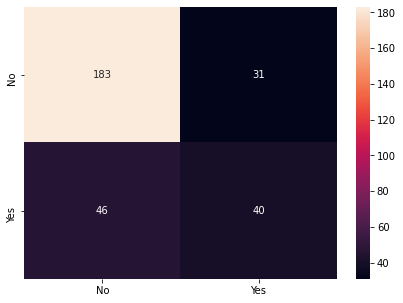

In [23]:
y_pred = dTreeR.predict(X_test)
# calling confusion matrix plotting function
plot_confusion_matrix(y_test,y_pred)

# Ensemble Learning

Generally:
- `Bagging` uses a complex `base_estimator` and runs different subsets on it.
- `Boosting` uses simple `base_estimator` and improves on it. If we use a complex model here, the later built models hurt and decrease accuracy.

### Bagging(Bootstrap Aggregation)

In [24]:
from sklearn.ensemble import BaggingClassifier

In [25]:
# base_estimator is the classifier on which subsets of data are tried; it's optional
# n_estimators is the number of models that will be built
bgcl = BaggingClassifier(base_estimator=dTree,n_estimators=50,random_state=1)

# it will form the same complex base_estimator
# bgcl = BaggingClassifier(n_estimators=50,random_state=1)

In [26]:
bgcl.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                  n_estimators=50, random_state=1)

In [27]:
print(bgcl.score(X_train,y_train))
print(bgcl.score(X_test,y_test))

1.0
0.7733333333333333


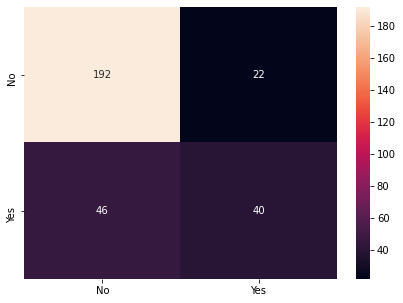

In [28]:
y_pred = bgcl.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

### AdaBoosting(Adaptive Boosting)

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [30]:
# base_estimator is the classifier on which subsets of data are tried; it's optional
# n_estimators is the number of models that will be built
# abcl = AdaBoostClassifier(base_estimator=dTree,n_estimators=50,random_state=1)

# it will form the simple base_estimator and run weights correction
# depth=1
abcl = AdaBoostClassifier(n_estimators=10,random_state=1)

In [31]:
abcl.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=10, random_state=1)

In [32]:
print(abcl.score(X_train,y_train))
print(abcl.score(X_test,y_test))

0.7657142857142857
0.74


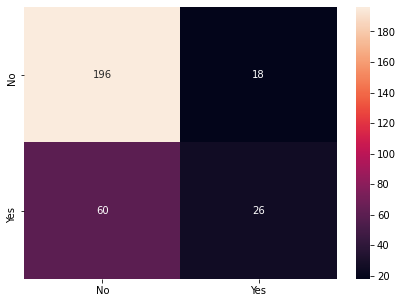

In [33]:
y_pred = abcl.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

### Gradient Boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
# it will form the simple base_estimator and run residual correction
gbcl = GradientBoostingClassifier(n_estimators=50,random_state=1)

In [36]:
gbcl.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=50, random_state=1)

In [37]:
print(gbcl.score(X_train,y_train))
print(gbcl.score(X_test,y_test))

0.8657142857142858
0.74


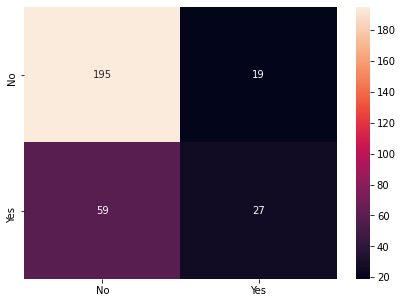

In [38]:
y_pred = gbcl.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rfcl = RandomForestClassifier(n_estimators=100,random_state=1,max_features=6)

In [41]:
rfcl.fit(X_test,y_test)

RandomForestClassifier(max_features=6, random_state=1)

In [42]:
print(rfcl.score(X_train,y_train))
print(rfcl.score(X_test,y_test))

0.7271428571428571
1.0


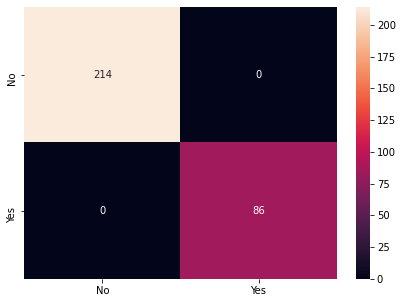

In [43]:
y_pred = rfcl.predict(X_test)
plot_confusion_matrix(y_test,y_pred)